### <center>Text Classification</center>

# Real / Fake Job Posting Prediction

## Background

This dataset is based on the Employment Scam Aegean Dataset (EMSCAD), which contains 18K job descriptions, approximately 800 of which are false. The data includes both textual and meta-information about the occupations. The dataset may be used to train classification algorithms to recognize fraudulent job descriptions.

## Problem Statement

False job postings are increasingly scamming and misleading job searchers, putting their safety, security, and well-being at danger. Solutions to safeguard innocent job seekers are clearly required, especially when layoffs and a recession increase the number of people looking for employment. Receiving telegram messages about a job opportunity from what looks to be a real recruiter is an example of a widespread problem in Singapore and other areas.

The goal of this project is to develop a classification model that uses text data features and meta-features to predict if a job description is fake or not and identify essential characteristics/features (words, entities, phrases) of job descriptions that are false.

## Importing Libraries

In [2]:
#Loading Libraries & importing required packages
import numpy as np
import pandas as pd
import nltk

#importing packages for plot & charts
import re
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


#importing package for pre processing & analysis of textual data
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from bs4 import BeautifulSoup


# importing packages for model classifications & evaluations
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix

## Loading the dataset

In [3]:
data = pd.read_csv("fake_job_postings.csv")

## Data Exploration

In [4]:
print(data.shape)

(17880, 18)


In [5]:
# Inspect first 5 roles of data
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
#Information on data columns 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [7]:
# Check for null values
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

### Data Cleaning For EDA

In [8]:
# Checking if has questions has any unique values
data['has_questions'].value_counts()

0    9088
1    8792
Name: has_questions, dtype: int64

In [9]:
# Checking if telecommuting has any unique values
data['telecommuting'].value_counts()

0    17113
1      767
Name: telecommuting, dtype: int64

In [10]:
# Checking if telecommuting has unique values
data['has_company_logo'].value_counts()

1    14220
0     3660
Name: has_company_logo, dtype: int64

* Columns with the no null values tends to have irrevalant values for the dataset.

In [11]:
# Checking if employment type has unqiue values
data['employment_type'].value_counts()

Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

In [12]:
# Removing columns that has very little correlation for the dataset
data = data
columns = ["job_id","salary_range","telecommuting","has_company_logo","has_questions"]
for col in columns:
    del data[col]    

In [13]:
# To inspect the head of dataframe after removing the irrevalant columns
data.head()

,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [14]:
# Filling the missing values
data.fillna('',inplace = True) 

### Exploratory Data Analysis

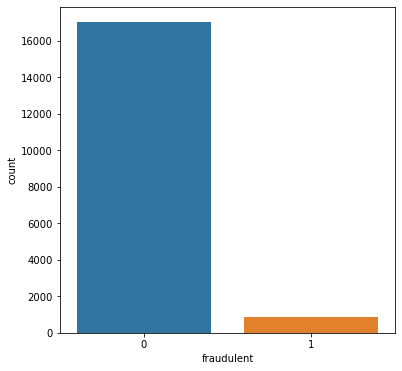

In [15]:
# To see how many jobs posted are fraud and real.
plt.figure(figsize=(6,6))

sns.countplot(data.fraudulent)

data.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

plt.show()

* There are very little fradulent job postings as compared to legitimate postings.
* This also indicates that the data is highly imbalaced.

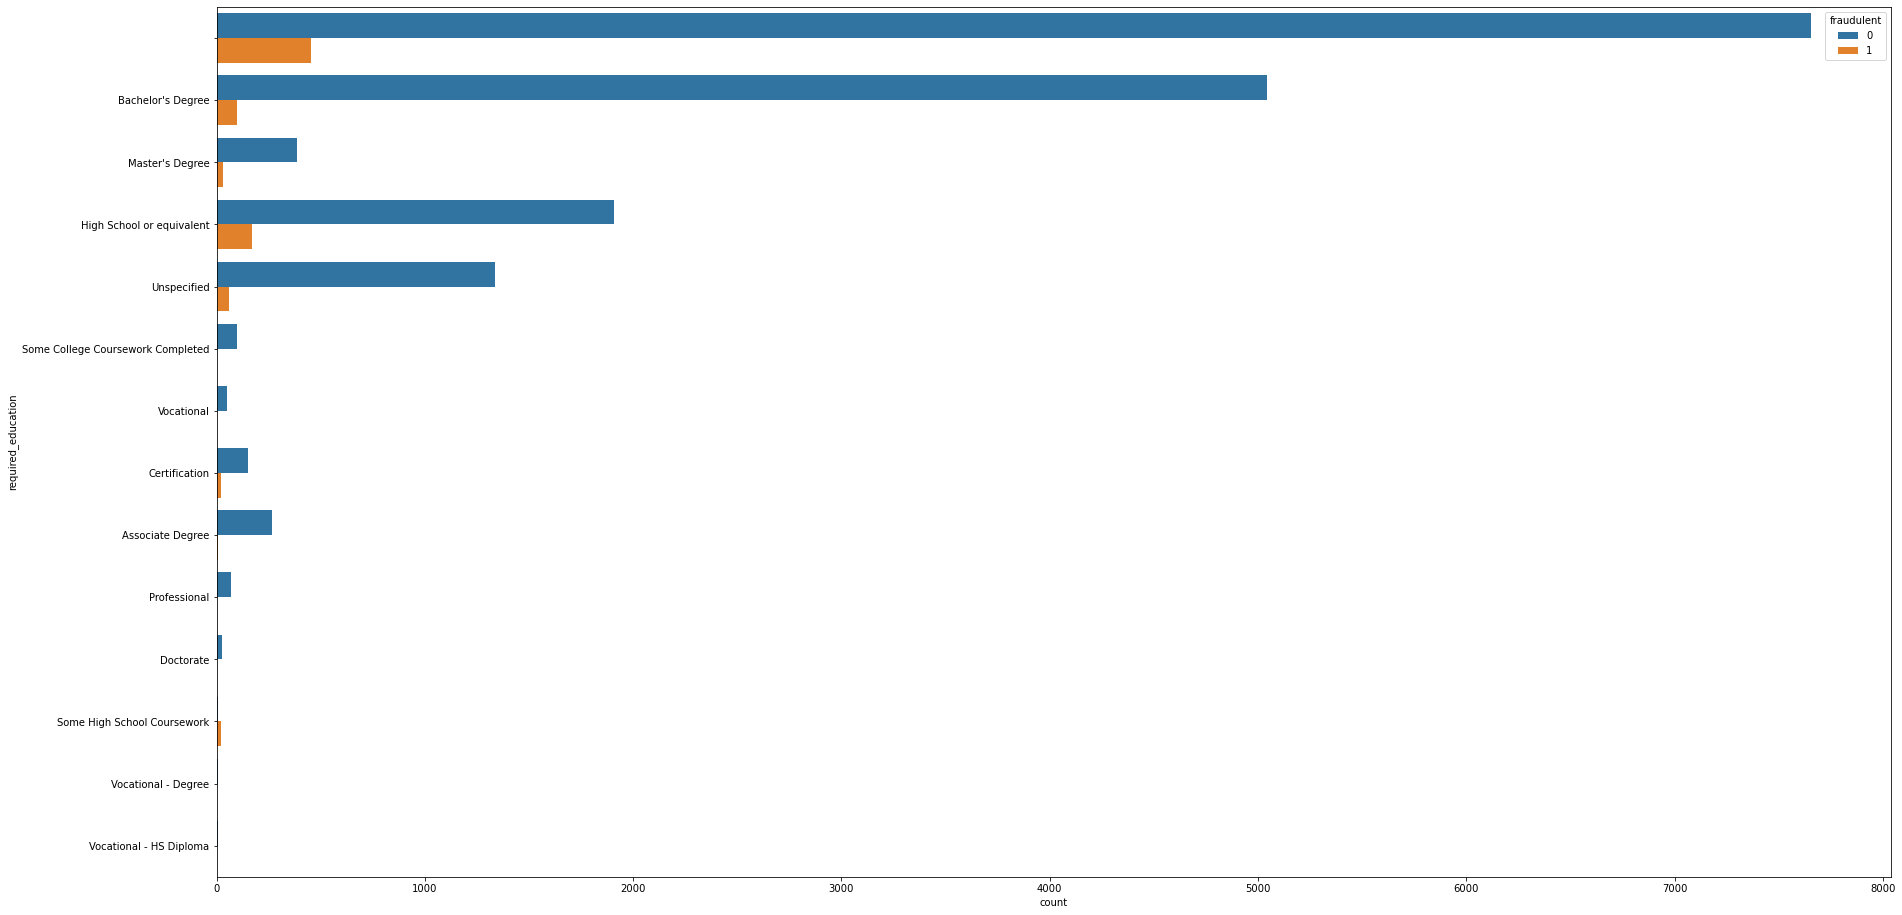

In [16]:
# To see what is the common required education for fraudelent & legitmate postings.
plt.figure(figsize=(30,16))
sns.countplot(hue='fraudulent',y='required_education',data=data)
plt.show()

* As seen in the countplot, high school is the targeted education for fradulent job postings.

{'Mid-Senior level': 3809, 'Entry level': 2697, 'Associate': 2297, 'Not Applicable': 1116, 'Director': 389, 'Internship': 381, 'Executive': 141}


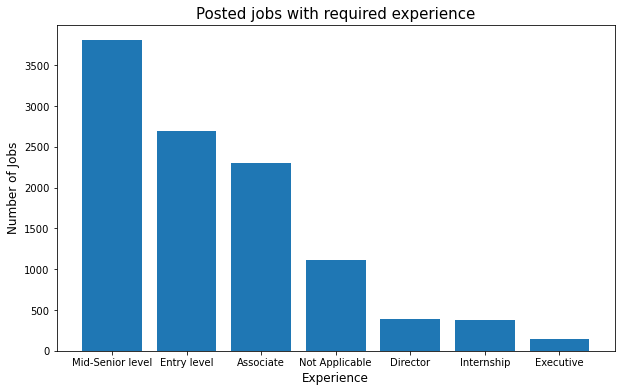

In [17]:
# To see the experience required in the posted jobs
exp = dict(data.required_experience.value_counts())
del exp['']
print(exp)
plt.figure(figsize =(10,6))
plt.bar(exp.keys(),exp.values())
plt.title("Posted jobs with required experience",size = 15)
plt.xlabel("Experience", size = 12)
plt.ylabel("Number of Jobs",size = 12)
plt.show()

* Mid-Senior Level experience is most required experience from job postings

Text(0.5, 1.0, 'Employment Type and Fraudulent Correlation')

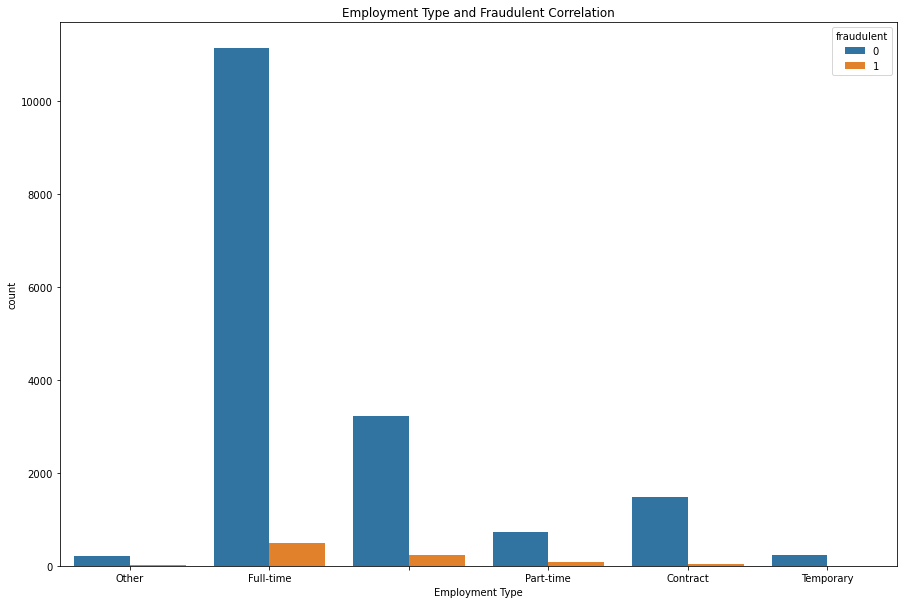

In [18]:
# To see the correlation between fradulent postings & employment type 
plt.figure(figsize = (15,10))
sns.countplot(x = "employment_type", hue = "fraudulent", data = data)
plt.xlabel("Employment Type")
plt.title("Employment Type and Fraudulent Correlation")

* As seen in the bar chart, full time employment are highly targeted for fraudulent job postings

In [19]:
# To see how many countries is in location column
data['location'].unique()

array(['US, NY, New York', 'NZ, , Auckland', 'US, IA, Wever', ...,
       'US, CA, los Angeles', 'CA, , Ottawa', 'GB, WSX, Chichester'],
      dtype=object)

Top 10 countries where jobs are posted
{'US': 10656, 'GB': 2384, 'GR': 940, 'CA': 457, 'DE': 383, 'NZ': 333, 'IN': 276, 'AU': 214, 'PH': 132}


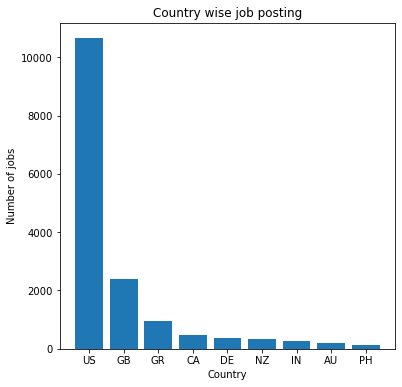

In [20]:
# countries where jobs are posted
def split(location):
    l = location.split(",")
    return l[0]
data['country'] = data.location.apply(split)

print("Top 10 countries where jobs are posted")
cntry = dict(data.country.value_counts()[:10])
del cntry['']

print(cntry)
plt.figure(figsize = (6,6))
plt.title("Country wise job posting")
plt.bar(cntry.keys(),cntry.values())
plt.ylabel("Number of jobs", size = 10)
plt.xlabel("Country", size = 10)
plt.show()

* As seen in the bar chart, US has the most job postings.
* This might indictate that US has the most fraudulent job postings as well.

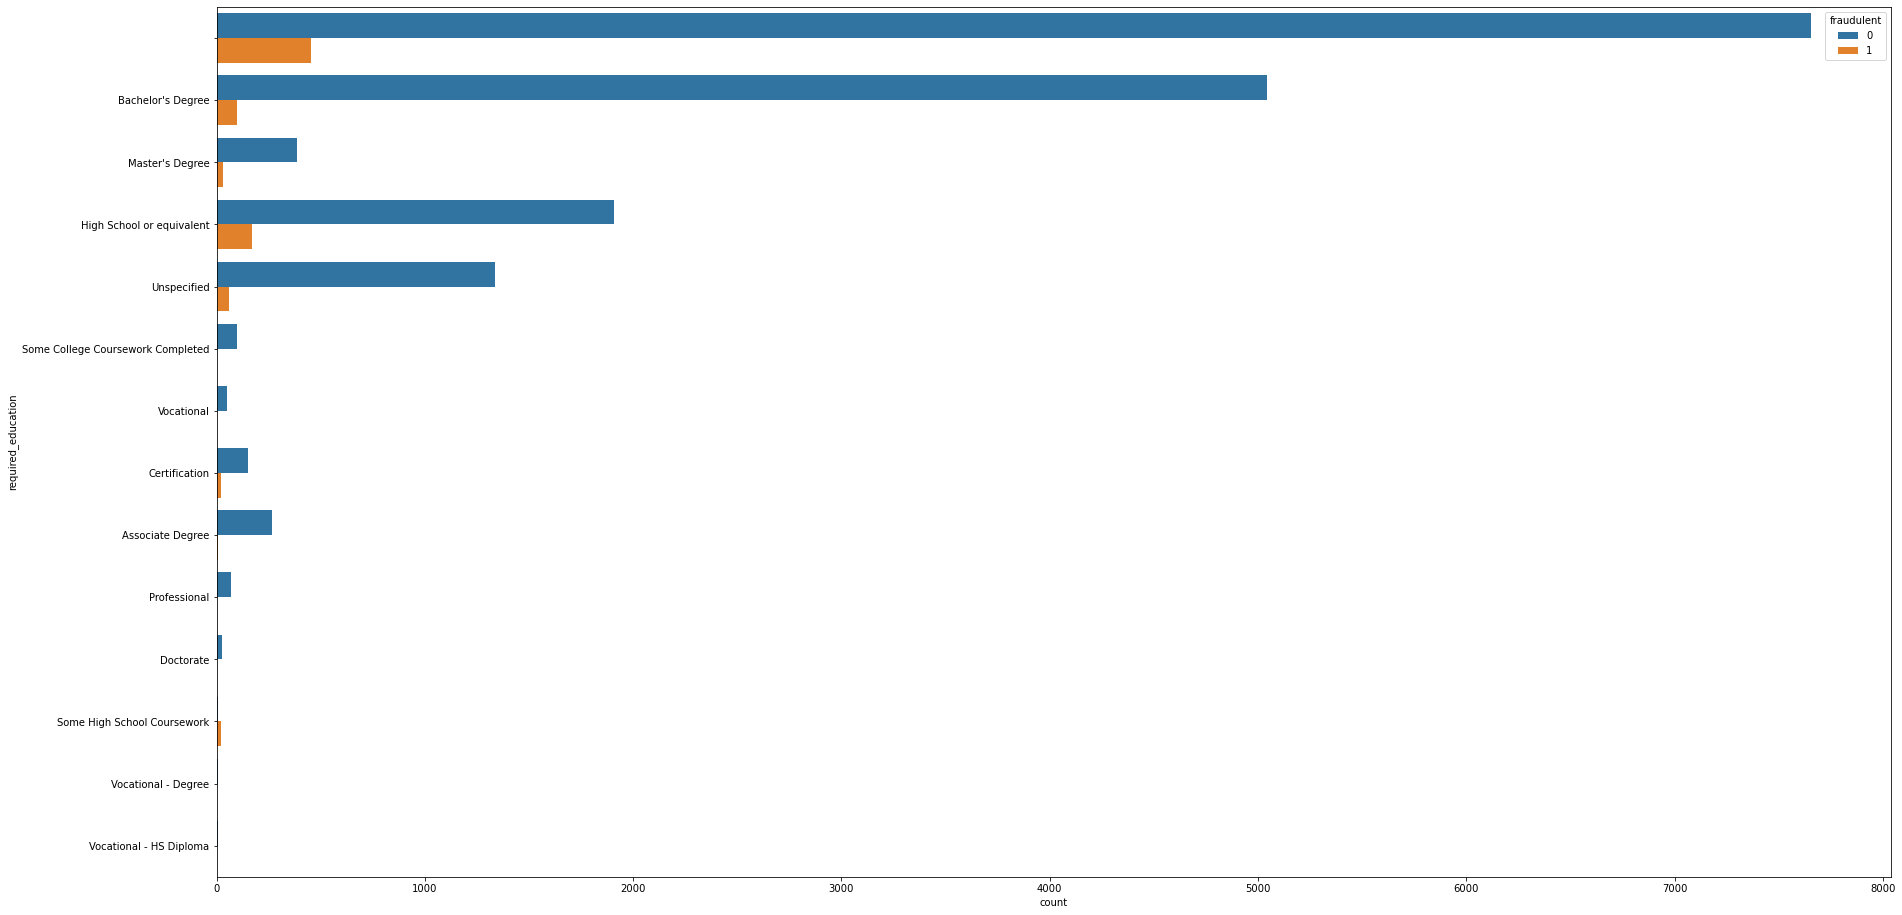

In [21]:
# To see what is the common required education for fraudelent & legitmate postings.
plt.figure(figsize=(30,16))
sns.countplot(hue='fraudulent',y='required_education',data=data)
plt.show()

As seen in the countplot, high school is the targeted education for fradulent job postings.

In [22]:
# To see what is the common titles in non - fraudulent postings
print(data[data.fraudulent == 0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


* English Teacher Abroad, Customer Service Associate & Graduates: English Teacher Abroad (Conversational) are common titles found in fraudelent job postings

In [23]:
# To see what is the common titles in fraudulent postings
print(data[data.fraudulent == 1].title.value_counts()[:10])

Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Data Entry Admin/Clerical Positions - Work From Home                    21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Name: title, dtype: int64


* Home Based Payroll Typist/Data Entry Clerks Positions Available, Data Entry Admin/Clerical Positions - Work From Home  & Cruise Staff Wanted *URGENT* are most common titles found in fraudulent postings.

## Textual Data Analysis

In [24]:
# Combining all the columns for textual data analysis
data['text'] = data['title']+' '+data['department']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']+' '+data['employment_type']+' '+data['required_experience']+' '+data['required_education']+' '+data['industry']+' '+data['function']

In [25]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

fraud_jobs = data[data.fraudulent == 1].text
real_jobs = data[data.fraudulent == 0].text
print(STOPWORDS)

{'afterwards', 'get', 'been', "'re", '’ll', 'latter', 'although', 'seems', 'an', 'more', 'nobody', 'hereafter', 'that', 'him', 'elsewhere', 'toward', 'me', 'he', 'and', 'she', 'over', 'some', 'those', 'whenever', 'my', 'we', 'thereby', 'really', 'every', 'many', 'either', 'may', 'something', 'go', 'hundred', 'with', 'anyone', 'made', 'then', 'around', 'nothing', '’ve', 'one', 'no', 'three', 'wherein', 'ourselves', 'used', 'had', 'from', 'except', 'ours', 'whom', 'again', 'namely', 'therein', 'various', 'wherever', 'neither', 'everywhere', 'about', 'up', 'serious', 'anything', 'whereas', 'even', 'would', 'became', 'bottom', 'who', 'herein', 'nor', 'beside', 'upon', 'beforehand', 'across', 'name', 'none', 'into', 'regarding', 'without', 'were', 'formerly', 'else', 'until', 'eleven', 'while', 'cannot', 'give', 'whereby', 'whereupon', 'often', 'less', 'unless', 'throughout', 'thereafter', 'call', 'am', 'sixty', 'them', 'yourself', 'what', 'make', 'yet', 'due', 'everyone', 'sometimes', 'too

* Most commonly used word found in fraudulent & non-fraudulent job postings.

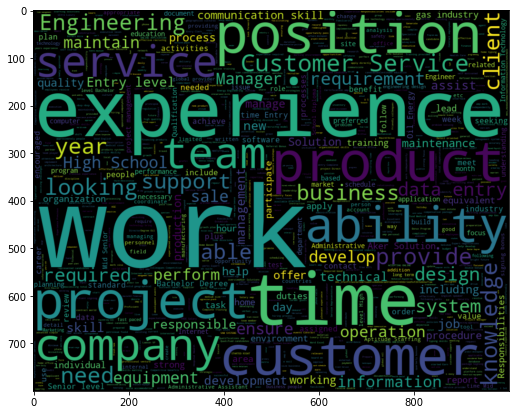

In [26]:
# word cloud shows the frequency of words token found in fraudulent jobs posting

plt.figure(figsize = (10,7))
wc = WordCloud(min_font_size = 3, max_words = 3000 ,width= 1000,height = 800, 
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs)))
plt.imshow(wc,interpolation = 'bilinear')

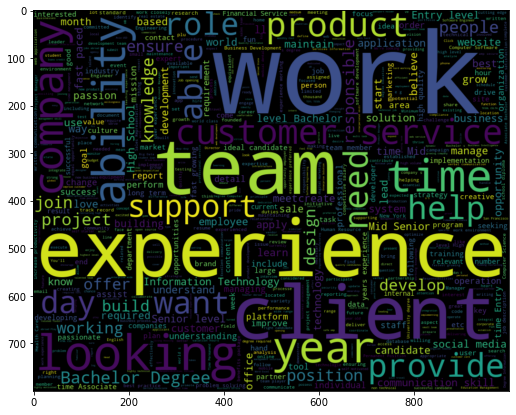

In [27]:
# word cloud shows the frequency of word token found in non - fraudulent jobs posting

plt.figure(figsize = (10,7))
wc = WordCloud(min_font_size = 3, max_words = 3000 ,width= 1000,height = 800, stopwords = STOPWORDS).generate(str(" ".join(real_jobs)))
plt.imshow(wc,interpolation = 'bilinear')

## Oversampling of data (Not in Use)

In [2]:
# data_1f = data[data.fraudulent == 1]
# original_data = data.copy()

# Merge the imbalanced & oversampled dataframe
# data = pd.concat([data] + [data_1f] * 7, axis=0)

* The goal of this code is to oversample the fraud data in order to balance the dataset's class distribution. The final dataset will have a more equal distribution of fraud and non-fraud instances after repeating the fraud data seven times.

In [3]:
#plt.figure(figsize=(10, 5))
#ax = sns.countplot(data.fraudulent)
#plt.title('The distribution of the target feature (fraudulent)')
# for p in ax.patches:
    #ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))
# plt.show()

* As seen in EDA, the dataset is highly imbalanced. Oversampling was attempted but removed on this project as the model accuracy went higher may overgeneralize, leading to high accuracy on the training set but poor performance on new data. 

## Feature Selection

In [28]:
# feature selection 
text_data = data[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]

* Top 5 features have been selected as these columns contains words & categorical features. This would help the pre-processing & model building stage.

In [29]:
text = text_data[text_data.columns[0:5]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = data['fraudulent']

## Data Pre Processing

In [30]:
# showing text without pre-processing
text.head(5)

0    Marketing Intern,We're Food52, and we've creat...
1    Customer Service - Cloud Video Production,90 S...
2    Commissioning Machinery Assistant (CMA),Valor ...
3    Account Executive - Washington DC,Our passion ...
4    Bill Review Manager,SpotSource Solutions LLC i...
dtype: object

In [31]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# applying tokenizer
text = text.apply(lambda x: tokenizer.tokenize(x))

In [32]:
#Removing the punctuation
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

text = text.apply(lambda x : combine_text(x))


In [33]:
# showing pre-processing applied to text
text.head(5)

0    Marketing Intern We re Food52 and we ve create...
1    Customer Service Cloud Video Production 90 Sec...
2    Commissioning Machinery Assistant CMA Valor Se...
3    Account Executive Washington DC Our passion fo...
4    Bill Review Manager SpotSource Solutions LLC i...
dtype: object

In [34]:
x=text
y=target

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=0)

* The dataset will be split into 70% training and 30% test set for model classificaiton

In [35]:
# Checking the length of the train and test set
print('Length of x_train:',len(x_train),'\nLength of y_train:',len(y_train))
print('Length of x_test:',len(x_test),'\nLength of y_test:',len(y_test))

Length of x_train: 12516 
Length of y_train: 12516
Length of x_test: 5364 
Length of y_test: 5364


In [36]:
# Applying Count Vectorizer
count_vectorizer = CountVectorizer()
x_train = count_vectorizer.fit_transform(x_train)
x_test = count_vectorizer.transform(x_test)    

* CountVectorizer is used to encode & breakdown textual data for model classification

## Classification Model Algorithms

### Logistic Regression

In [37]:
lr=LogisticRegression()
lr.fit(x_train,y_train)

#predicting the test set result
y_pred=lr.predict(x_test)

from sklearn import metrics
# printing the accurancy of the model
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9847129008202834


In [38]:
# printing confusion matrix
print(confusion_matrix(y_test, y_pred))
# printing classification report
print (classification_report(y_test, y_pred))

[[5102   35]
 [  47  180]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5137
           1       0.84      0.79      0.81       227

    accuracy                           0.98      5364
   macro avg       0.91      0.89      0.90      5364
weighted avg       0.98      0.98      0.98      5364



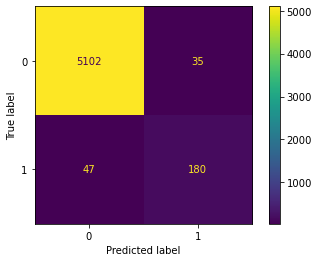

In [39]:
plot_confusion_matrix(lr, x_test, y_test) 
plt.show()

* There is room for improvement in terms of raising accuracy score by utilising grid search for Logistic Regression. Grid-search would be used to determine the ideal model hyperparameters that result in the more 'accurate' predictions.

### Logistic Regression Hyperparameter Tuning Using Grid Search

In [40]:
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression()
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty_options = ['l1', 'l2']
param_grid = dict(C = c_values, penalty = penalty_options)
grid_tfidf = GridSearchCV(log_reg, param_grid = param_grid, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose=1)
grid_tfidf.fit(x_train, y_train)
log_reg_pred = grid_tfidf.predict(x_test)
print ("Best score: ",grid_tfidf.best_score_)
print ("Best parameter: ",grid_tfidf.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best score:  0.9741894684576324
Best parameter:  {'C': 0.1, 'penalty': 'l2'}


In [41]:
#print (roc_auc_score(y_test, log_reg_pred))
print (classification_report(y_test, log_reg_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5137
           1       0.90      0.77      0.83       227

    accuracy                           0.99      5364
   macro avg       0.94      0.88      0.91      5364
weighted avg       0.99      0.99      0.99      5364



* The accurancy score improves after utilizing the grid search to fine-tune the parameters. The precision & f1 score is enhanced  after hyperparameter optimization using grid search.

### Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest=RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=1)

#Train the model using the training sets
forest.fit(x_train,y_train)

#predicting the test set result
y_pred=forest.predict(x_test)

from sklearn import metrics
# prining the Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9839671886651753


In [41]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print (classification_report(y_test, y_pred))

[[5133    4]
 [  82  145]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5137
           1       0.97      0.64      0.77       227

    accuracy                           0.98      5364
   macro avg       0.98      0.82      0.88      5364
weighted avg       0.98      0.98      0.98      5364



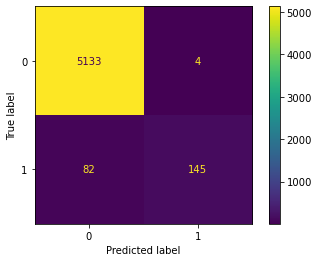

In [49]:
plot_confusion_matrix(forest, x_test, y_test) 
plt.show()

* Same thing as follows, there is room for improvement in terms of raising accuracy score by utilising grid search for Random Forest Classifier. Grid-search would be used to determine the ideal model hyperparameters that result in the more 'accurate' predictions.

### Random Forest Hyperparameter Tuning Using Grid Search

In [43]:
#hyperparameter best n_estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
n_estimators_range = [1, 2, 4,8,16,32,64,100,200]
param_grid_rf = dict(n_estimators = n_estimators_range)
grid_rf = GridSearchCV(rf, param_grid_rf, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)
grid_rf.fit(x_train, y_train)
rf_pred = grid_rf.predict(x_test)
print ("Best score:",grid_rf.best_score_)
print ("Best parameter:",grid_rf.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best score: 0.9843737217163456
Best parameter: {'n_estimators': 200}


In [47]:
print (classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5137
           1       0.97      0.66      0.79       227

    accuracy                           0.98      5364
   macro avg       0.98      0.83      0.89      5364
weighted avg       0.98      0.98      0.98      5364



* The accurancy score does not change before and after tuning. 98% is most likely the model's best accuracy score, and there isn't much that can be improved to improve the model's performance except the recall & f1 score.

### KNN 

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(x_train, y_train)

# predict the response
y_pred = knn.predict(x_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9677479492915735


In [67]:
from sklearn.neighbors import KNeighborsClassifier

print("accuracy: {}".format(accuracy_score(y_test, y_pred)))
print (classification_report(y_test, y_pred))

accuracy: 0.9677479492915735
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5137
           1       0.60      0.74      0.66       227

    accuracy                           0.97      5364
   macro avg       0.79      0.86      0.82      5364
weighted avg       0.97      0.97      0.97      5364



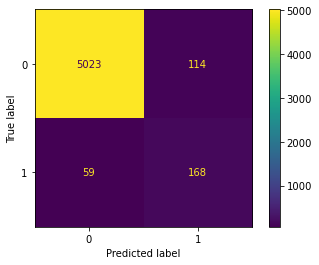

In [68]:
plot_confusion_matrix(knn, x_test, y_test) 
plt.show()

* K-fold cross validation may be used to tune the KNN model by determining the error rate for a portion of the training set. Cross-validation is a technique for evaluating predictive models that divides the original sample into a training set for training the model and a test set for evaluating it, which reduces overfitting.

### KNN tuning

In [69]:
from sklearn.model_selection import cross_val_score
# creating odd list of K for KNN
neighbors = list(range(1, 30,2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 13


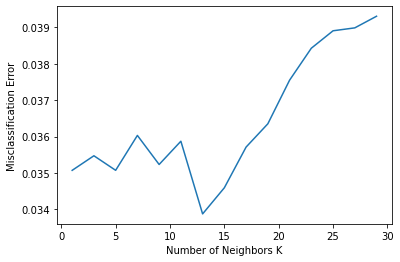

In [70]:
#changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()

In [71]:
# represent learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=13)

# fitting the model
knn.fit(x_train, y_train)

# predict the response
pred = knn.predict(x_test)

In [72]:
# evaluate accuracy
print("accuracy: {}".format(accuracy_score(y_test, pred)))
print (classification_report(y_test, pred))

accuracy: 0.9696122296793438
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5137
           1       0.71      0.48      0.57       227

    accuracy                           0.97      5364
   macro avg       0.84      0.74      0.78      5364
weighted avg       0.97      0.97      0.97      5364



* The accuracy score increase somewhat but it is always important to determine the ideal number of neighbors to get a high accurancy score.

### Decision Tree

In [82]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
dt = DecisionTreeClassifier()
# Train Decision Tree Classifer
dt = dt.fit(x_train,y_train)
#Predict the response for test dataset
y_pred = dt.predict(x_test)

In [83]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print (classification_report(y_test, y_pred))

Accuracy: 0.9807979120059657
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5137
           1       0.77      0.78      0.78       227

    accuracy                           0.98      5364
   macro avg       0.88      0.89      0.88      5364
weighted avg       0.98      0.98      0.98      5364



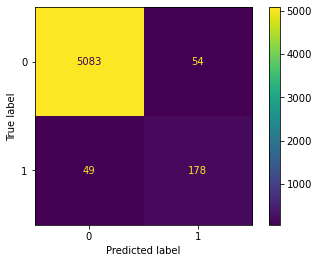

In [84]:
plot_confusion_matrix(dt, x_test, y_test) 
plt.show()

### Decision Tree Tuning 

In [92]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv_method = StratifiedKFold(n_splits=5,shuffle=True, random_state=999)

In [96]:
df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [5,10,15,20],
             'min_samples_split': [2,5]}

dt2 = GridSearchCV(df_classifier, 
                     params_DT, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

dt2.fit(x_train, y_train);
print("Best parameter",gs_DT2.best_params_)
print("Best score",gs_DT2.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameter {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5}
Best score 0.9741131089976374


In [97]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(criterion="entropy", max_depth=20)

# Train Decision Tree Classifer
dt = dt.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = dt.predict(x_test)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.977069351230425


In [98]:
print(confusion_matrix(y_test, y_pred))
print (classification_report(y_test, y_pred))

[[5090   47]
 [  76  151]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5137
           1       0.76      0.67      0.71       227

    accuracy                           0.98      5364
   macro avg       0.87      0.83      0.85      5364
weighted avg       0.98      0.98      0.98      5364



* The accuracy score does not change before and after tuning. Probably, 98% is the best accuracy score for the baseline model, and there isn't much further that can be done to improve the model's performance.

## Model Performance Comparison

In [140]:
# mean score for Logistic Regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv_method_ttest = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
cv_results_LR = cross_val_score(estimator=grid_tfidf.best_estimator_,
                                X=x_test,
                                y=y_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_LR.mean()

0.9584968784863717

In [141]:
# mean score for Random Forest
cv_results_RF = cross_val_score(estimator=grid_rf.best_estimator_,
                                X=x_test,
                                y=y_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_RF.mean()

0.9700103341181749

In [142]:
# mean score for Decision Tree
cv_results_DT = cross_val_score(estimator=gs_DT2.best_estimator_,
                                X=x_test,
                                y=y_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_DT.mean()

0.8584261058797829

In [143]:
# Mean score for KNN
scores_knn = cross_val_score(knn, x_test, y_test, cv=cv_method_ttest,  
                             n_jobs=-2,scoring='roc_auc')
scores_knn.mean()

0.8904749614107279

* Based on the results, we can conclude that Random Forest is statistically the best model in terms of AUC in comparison to the test data, with a 97% accuracy.

## Classification Report for Models

In [148]:
print("\nClassification report for Logistic Regression")
print (classification_report(y_test, log_reg_pred))

print("\nClassification report for K-Nearest Neighbor") 
print (classification_report(y_test, pred))

print("\nClassification report for RandomForest") 
print (classification_report(y_test, rf_pred))

print("\nClassification report for Decision tree") 
print(classification_report(y_test,y_pred))


Classification report for Logistic Regression
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5137
           1       0.90      0.77      0.83       227

    accuracy                           0.99      5364
   macro avg       0.94      0.88      0.91      5364
weighted avg       0.99      0.99      0.99      5364


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5137
           1       0.71      0.48      0.57       227

    accuracy                           0.97      5364
   macro avg       0.84      0.74      0.78      5364
weighted avg       0.97      0.97      0.97      5364


Classification report for RandomForest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5137
           1       0.97      0.64      0.77       227

    accuracy                           0.98      

* We identify job posting fraud using the word and description, and recall is chosen as the performance metric which indicates true positive rate. Recall ensures that the model finds all cases with a positive target. As a result, logistic regression is the top performer since it has the greatest recall score.

## Confusion Matrix for Models

In [149]:
print("\nClassification report for Logistic Regression")
print (metrics.confusion_matrix(y_test, log_reg_pred))

print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(y_test, pred))

print("\nClassification report for RandomForest") 
print (metrics.confusion_matrix(y_test, rf_pred))

print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(y_test, y_pred))


Classification report for Logistic Regression
[[5117   20]
 [  53  174]]

Confusion matrix for K-Nearest Neighbor
[[5091   46]
 [ 117  110]]

Classification report for RandomForest
[[5133    4]
 [  82  145]]

Confusion matrix for Decision Tree
[[5114   23]
 [  98  129]]


* The confusion matrix are compatible with the classificaiton report. This contrast with our finding that Random Forest is clearly the greatest performer in terms of the AUC metric.

## Conclusion

The Random Forest model with the top 5 features achieved the highest cross-validation AUC score on the training data. It also outperformed other models like KNN and Decision Tree in terms of AUC. However, the Logistic Regression model had the highest recall score on the test data. The results suggest that the models are robust to the number of features used, and a limited number of features were selected to avoid overfitting and make the models easier to train and understand. The features were selected based on the number of words they contained, and the 5 selected features had more words. Overall, the goal of building a reliable classification model for detecting fraudulent job advertisements using words and description was achieved with high accuracy.